# Minimal example for PSM

In [1]:
import numpy as np
import pandas as pd
from yapsm import psm
from yapsm.utils import summary_imbalance, plot_imbalance

In [2]:
# make up some data in 2D
n_trt =100
n_ctl = 1000
ctl = pd.DataFrame(np.random.normal(0, 2, size=(n_ctl, 2)), index=[f"ctl_{i}" for i in range(n_ctl)], columns=['x1','x2'])
trt = pd.DataFrame(np.random.normal(1, 1, size=(n_trt, 2)), index=[f"trt_{i}" for i in range(n_trt)], columns=['x1','x2'])

ctl['group'] = 0
trt['group'] = 1
data = pd.concat([ctl, trt])
data.head()

,x1,x2,group
ctl_0,0.020441,0.154598,0
ctl_1,-3.489034,2.221325,0
ctl_2,1.999674,-0.768249,0
ctl_3,-1.766482,0.944485,0
ctl_4,0.368852,-1.503444,0


## Fitting/Matching with PSM

In [3]:
# apply PSM
p = psm.Yapsm(
    data,
    yvar="group",
    group_ctl=0,  #'ctl',
    group_trt=1,  #'trt'
)
# p.fit_scores(balance=False)
p.fit_scores(balance=True)
p.predict_scores()

INFO:yapsm.psm:Average Classification Accuracy: 72.4%


`p.predict_scores()` adds a `scores` column

In [4]:
p.data.head()

,x1,x2,group,scores
ctl_0,0.020441,0.154598,0,0.383192
ctl_1,-3.489034,2.221325,0,0.199464
ctl_2,1.999674,-0.768249,0,0.546691
ctl_3,-1.766482,0.944485,0,0.255313
ctl_4,0.368852,-1.503444,0,0.280564


In [5]:
optimal_matching = p.match_optimal(knn=150, n_max=1, caliper=0.25)
df_matched = p.get_psmatched_dataset(optimal_matching)

INFO:yapsm.optimal_match:kNN query (k=150)
INFO:yapsm.optimal_match:constructing Flow graph
INFO:yapsm.optimal_match:solving flow
INFO:yapsm.psm:Mapped 100 TRT  to 100 CTL
INFO:yapsm.psm:Total cost 0.058


`df_matched` contains less samples, but they're matched between `trt` and `ctl`

In [6]:
df_matched.head()

,x1,x2,group,scores
trt_6,-2.055118,0.441367,1,0.197221
trt_41,1.953665,1.693663,1,0.753902
trt_47,1.855952,0.512287,1,0.648945
trt_90,1.399925,1.311443,1,0.666741
ctl_797,0.902804,1.919348,0,0.662576


## Visualizing the PSM
imbalance before PSM: `x1`, `x2` (ignore `scores`) between groups
- absolute differences (`mean_diff`)
- standardized differences (`std_mean_diff`)

In [7]:
summary_imbalance(data, 'group')

group,0,1,mean_diff,std,std_mean_diff,std_treat,std_treat_mean_diff,var_ratio
x1,-0.076582,1.107218,1.183800,1.886644,0.627463,0.955412,1.239047,0.246857
x2,0.041572,1.072219,1.030647,2.002270,0.514739,1.027781,1.002788,0.250967
scores,0.396317,0.602002,0.205685,0.234265,0.878005,0.144575,1.422693,0.383857


imbalance **after** PSM is reduced significantly

In [8]:
summary_imbalance(df_matched, 'group')

group,0,1,mean_diff,std,std_mean_diff,std_treat,std_treat_mean_diff,var_ratio
x1,1.035752,1.107218,0.071466,1.211393,0.058995,0.955412,0.074802,0.448693
x2,1.170722,1.072219,-0.098504,1.389205,-0.070907,1.027781,-0.095841,0.374847
scores,0.602033,0.602002,-0.000030,0.144230,-0.000211,0.144575,-0.000211,0.999485


Love plot

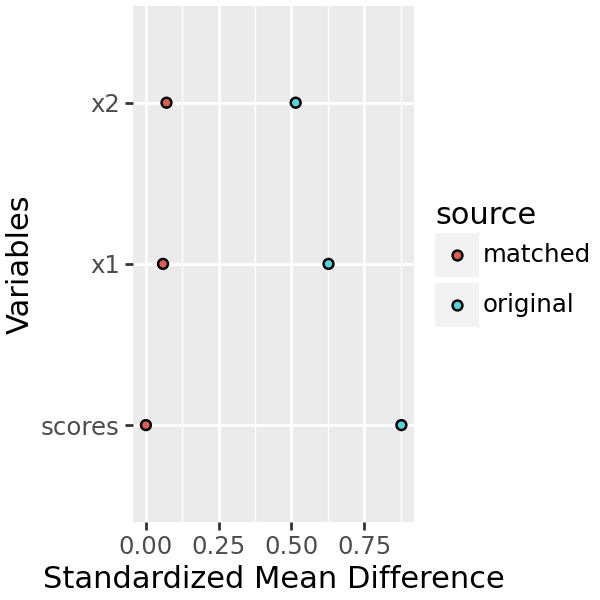

In [9]:
import plotnine as pn
plot_imbalance(data, df_matched, 'group') + pn.theme(figure_size=(3,3)) 

# Plot the matching

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
def plot_match(optimal_map, ctl, trt):

    _d = pd.concat([ctl, trt])
    plt.figure(figsize=(5, 5))
    plt.scatter(_d.x1, _d.x2, c=_d.scores, s=1)
    plt.title('PSM scores')
    
    plt.figure(figsize=(5, 5))
    plt.scatter(ctl.x1, ctl.x2, c="grey", s=1)
    plt.scatter(
        trt.x1,
        trt.x2,
        s=1, color='red'
    )

    for trt_ix, ctl_index in optimal_map.items():
        plt.plot(
            [ctl.loc[ctl_index, "x1"], trt.loc[trt_ix, "x1"]],
            [ctl.loc[ctl_index, "x2"], trt.loc[trt_ix, "x2"]],
            linewidth=1, alpha=0.5
        )
    plt.title('PSM matches')
    plt.show()
    

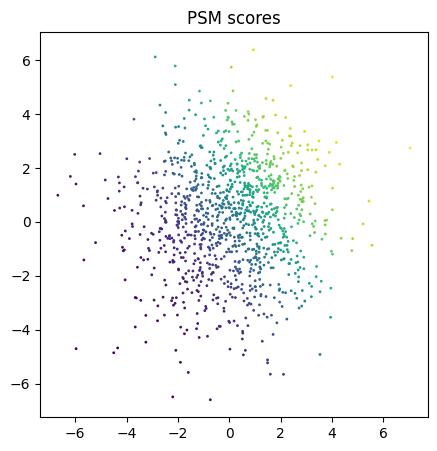

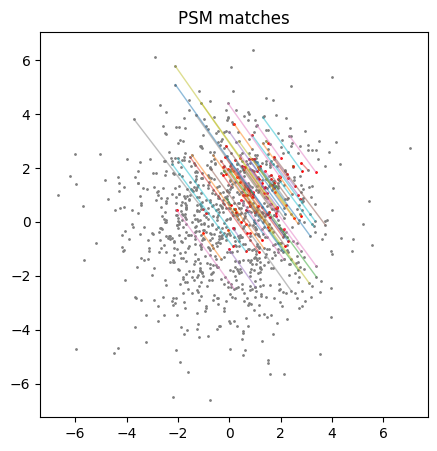

In [11]:
ctl, trt = p._get_ctl_treat_split(p.data)
plot_match(optimal_matching, ctl, trt)